In [1]:
import os
os.chdir("../")
os.environ["OMP_NUM_THREADS"] = "11"

In [2]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
COLORS = list(TABLEAU_COLORS.values())

In [3]:
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, accuracy_score

In [4]:
from scripts.data.load import load_cora
from scripts.graph.plotting import histplot

[[0.12156863 0.46666667 0.70588235]
 [1.         0.49803922 0.05490196]
 [0.17254902 0.62745098 0.17254902]
 [0.83921569 0.15294118 0.15686275]
 [0.58039216 0.40392157 0.74117647]
 [0.54901961 0.3372549  0.29411765]
 [0.89019608 0.46666667 0.76078431]
 [0.49803922 0.49803922 0.49803922]
 [0.7372549  0.74117647 0.13333333]
 [0.09019608 0.74509804 0.81176471]]


In [5]:
ids, data, target, edges = load_cora()

In [6]:
def visualize_encoding_spread(X, Y):
    pca = PCA(n_components=2)
    x,y = pca.fit_transform(X).T
    
    label_idxs = {l:i for i,l in enumerate(set(Y))}
    label_idxs = [label_idxs[l] for l in Y]
    c = [COLORS[i%len(COLORS)] for i in label_idxs]
    plt.scatter(x,y,c=c,marker=".")

In [7]:
def match_labels(y_pred, y_actual):
    cls_map = defaultdict(lambda: defaultdict(int))
    for a, b in zip(y_pred, y_actual):
        cls_map[a][b] += 1
    
    for _cls, counts in cls_map.items():
        best_label = sorted(counts.items(), key=lambda x:x[1], reverse=True)[0][0]
        cls_map[_cls] = best_label
    
    return [cls_map[y] for y in y_pred]

In [8]:
def evaluate(model, X):
    y_pred = model.fit_predict(X)
    acc = round(accuracy_score(target, match_labels(y_pred, target)), 2)
    nmi = round(normalized_mutual_info_score(target, y_pred),2)
    ars = round(adjusted_rand_score(target, y_pred),2)
    print(f"acc: {acc}  nmi: {nmi} ars: {ars}")

In [9]:
def normalize(X):
    return (X.T /((X**2).sum(axis=1)**0.5)).T

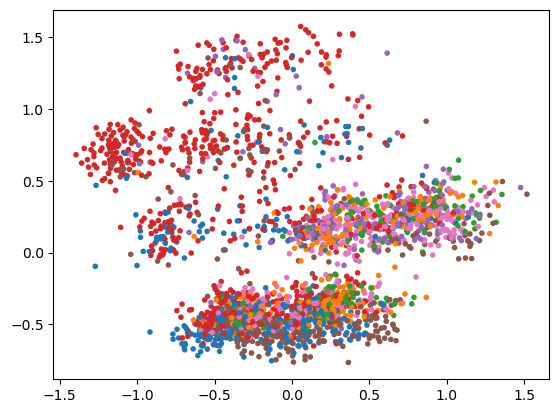

In [10]:
visualize_encoding_spread(data, target)

In [11]:
pca = PCA(n_components=64)
X = normalize(pca.fit_transform(data))

In [12]:
model = KMeans()
evaluate(model, X)

acc: 0.38  nmi: 0.13 ars: 0.09


## Reference Vectors

In [13]:
id_idx_map = {_id: i for i, _id in enumerate(ids)}
references = {_id: [u for u, v in edges if v == _id] for _id in ids}

In [14]:
def reference_vector(_id):
    vector = data[id_idx_map[_id]].copy()
    reference = np.zeros(vector.shape)
    refs = references[_id]
    for r in refs:
        reference = reference + data[id_idx_map[r]]/len(refs)
    return np.array(list(vector)+list(reference))

In [15]:
X_prime = np.array([reference_vector(ids[i]) for i, x in enumerate(X)])

In [16]:
pca = PCA(n_components=64)
X_prime = normalize(pca.fit_transform(X_prime))

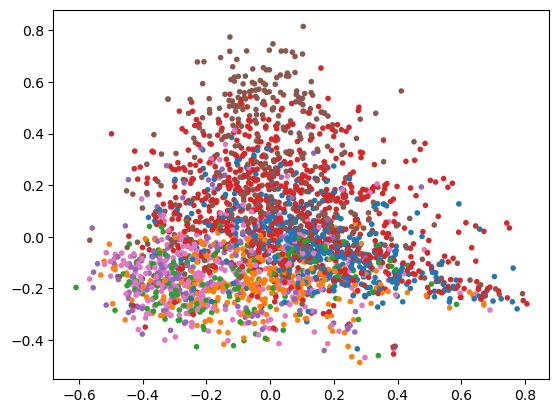

In [17]:
visualize_encoding_spread(X_prime, target)

In [18]:
model = KMeans(n_clusters=7)
evaluate(model, X_prime)

acc: 0.58  nmi: 0.34 ars: 0.24


## Initialize to clusters identified by adjacency matrix

In [19]:
adjacency = np.zeros((len(ids),len(ids)))
for u,v in edges:
    u_idx = id_idx_map[u]
    v_idx = id_idx_map[v]
    adjacency[v_idx,u_idx] = 1

In [20]:
pca = PCA(n_components=32)
X_adj = normalize(pca.fit_transform(adjacency))

In [21]:
model = KMeans(n_clusters=7)
init_classes = model.fit_predict(X_adj)

In [22]:
init_centers = []
for c in set(init_classes):
    init_centers.append(X_prime[init_classes==c].mean(axis=0))

In [23]:
model = KMeans(n_clusters=7, init=init_centers)
evaluate(model, X_prime)

acc: 0.56  nmi: 0.31 ars: 0.23


C:\Users\stans\Documents\Projects\git\IR-pa3\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1307: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)
